<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/cnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install git+https://github.com/pvigier/perlin-numpy

  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-57ierh9v
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-57ierh9v
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Preparing metadata (setup.py) ... done
  Created wheel for perlin-numpy: filename=perlin_numpy-0.0.0-py3-none-any.whl size=4723 sha256=7b0bd36970270b3f190f8ad7c6204b1858574abd5859981088139d8389054ab1
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kcler_4/wheels/d0/67/1b/569e9d602b147a53e4ab67a3592944572d7d3886dc3a2e095e
Successfully built perlin-numpy


In [2]:
pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56263 sha256=0452ed87cd646b80475d293fc473a3491777c45fc153756f9b11d47d0d200ef2
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


In [3]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 3.6 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
import numpy as np
from perlin_numpy import generate_perlin_noise_2d
import noise
from noise import pnoise2
from noise import snoise3
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


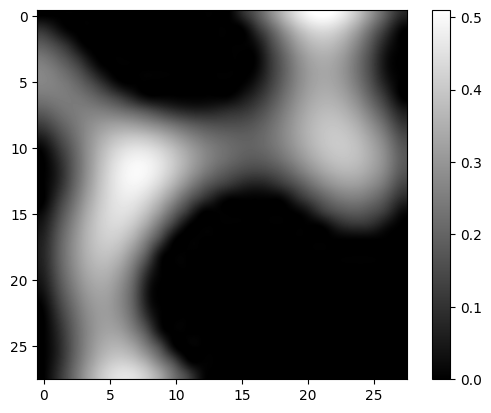

In [5]:
#np.random.seed(1)
noise = generate_perlin_noise_2d((28, 28), (2, 2))
noise = np.clip(noise,0,1)
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()

In [6]:


# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
#x_train = (x_train.astype("float32") - 127.5) / 127.5
#y_train = y_train.reshape(-1, 1)
x_train = (x_train.astype("float32")) / np.max(x_train)


# Example usage
image_index = 0  # Index of the image you want to retrieve
image = x_train[image_index]
print(image.shape)
print(x_train.shape[0])


11490434/11490434 [==============================] - 0s 0us/step
(28, 28)
60000


In [7]:
print(np.max(x_train))

1.0


In [160]:
x_train2 = x_train[:500]
y_train2 = y_train[:500]

In [9]:
class AddNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, stddev, probability, **kwargs):
        super(AddNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev
        self.probability = probability

    def call(self, inputs, training=None):
        if training:

            if tf.random.uniform(()) < self.probability:
                perlin = generate_perlin_noise_2d((28, 28), (2, 2))
                perlin = tf.convert_to_tensor(perlin, dtype=tf.float32)
                perlin = tf.clip_by_value(perlin, 0, 1)
                perlin = tf.reshape(perlin, (28, 28, 1))
                noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
                output = inputs + noise * perlin
                return tf.clip_by_value(output, 0, 1)
            else:
                return inputs
        return inputs

In [10]:
class AddNoiseLayertest(tf.keras.layers.Layer):
    def __init__(self, stddev=.5, **kwargs):
        super(AddNoiseLayertest, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:

              perlin = generate_perlin_noise_2d((28, 28), (2, 2))
              perlin = tf.convert_to_tensor(perlin, dtype=tf.float32)
              perlin = tf.clip_by_value(perlin, 0, 1)
              perlin = tf.reshape(perlin, (28, 28, 1))
              noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
              output = inputs + noise * perlin
              return tf.clip_by_value(output, 0, 1)
        return inputs

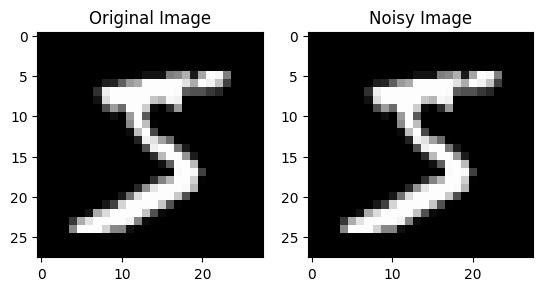

(28, 28, 1)


In [11]:
# Create a random 28x28 image tensor
image = x_train[0]
image = np.expand_dims(image,-1)
# Instantiate the RandomNoiseLayer
GaussianPerlinNoiseLayer = AddNoiseLayer(.5,.5)

# Pass the image through the layer
noisy_image = GaussianPerlinNoiseLayer(image,training=True)

# Display the original and noisy images
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')  # Display the original image
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(noisy_image), cmap='gray')  # Display the noisy image
plt.title('Noisy Image')
plt.show()

print(noisy_image.shape)

In [12]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.activation = tf.keras.activations.get(activation)

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')
        self.shortcut_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        shortcut = self.shortcut(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        x = tf.keras.layers.add([x, shortcut])
        x = self.activation(x)

        return x

In [13]:
class CustomFullAug(tf.keras.layers.Layer):
    def __init__(self, probability=.2,rot_factor=.2,height=.2,width=.2,stdev=.2):
        super(CustomFullAug, self).__init__()
        self.probability = probability

        self.rot_factor = rot_factor
        self.height = height
        self.width = width
        self.stdev = stdev
        self.flip_layer = tf.keras.layers.RandomFlip()
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=rot_factor)
        self.noise_layer = AddNoiseLayertest()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            #flipped_data = self.flip_layer(inputs, training=training)
            rotated_data = self.rotation_layer(inputs, training=training)
            zoomed_data = self.zoom_layer(rotated_data, training=training)
            noised = self.noise_layer(zoomed_data, training=training)
            return noised
        else:
            return inputs

In [14]:

class CustomFlipLayer(tf.keras.layers.Layer):
    def __init__(self, probability):
        super(CustomFlipLayer, self).__init__()
        self.probability = probability
        self.flip_layer = tf.keras.layers.RandomFlip()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            flipped_data = self.flip_layer(inputs, training=training)
            return flipped_data
        else:
            return inputs

In [15]:
class CustomRotationLayer(tf.keras.layers.Layer):
    def __init__(self, probability, factor):
        super(CustomRotationLayer, self).__init__()
        self.probability = probability
        self.factor = factor
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=factor)

    def call(self, inputs, training=True):
        if tf.random.uniform(()) < self.probability:
            rotated_data = self.rotation_layer(inputs, training=training)
            return rotated_data
        else:
            return inputs

In [16]:
class CustomZoomLayer(tf.keras.layers.Layer):
    def __init__(self, probability,height, width):
        super(CustomZoomLayer, self).__init__()
        self.probability = probability
        self.height = height
        self.width = width
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)

    def call(self, inputs, training=False):
        if tf.random.uniform(()) < self.probability:
            zoomed_data = self.zoom_layer(inputs, training=training)
            return zoomed_data
        else:
            return inputs

In [154]:
def build_generator():
    noise_shape = (28,28,1)
    noise = layers.Input(shape=noise_shape)
    input_digit = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 28*28)(input_digit)
    digit_embedding = layers.Reshape((28, 28, 1))(digit_embedding)

    x = layers.Concatenate()([noise, digit_embedding])

    x1 = layers.Conv2D(128, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.5)(x1)

    x2 = layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.5)(x2)

    x3 = layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Dropout(0.5)(x3)

    x4 = layers.Conv2DTranspose(128, 2, strides=1, padding="same", activation="relu")(x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Dropout(0.5)(x4)

    x5 = layers.Conv2DTranspose(128, 2, strides=1, padding="same", activation="relu")(x4)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Dropout(0.5)(x5)

    x6 = layers.Conv2DTranspose(128, 2, strides=2, padding="same", activation="relu")(x5)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Dropout(0.5)(x6)

    # Upsample x3 to match the shape of x6
    x3_upsampled = layers.UpSampling2D()(x3)
    x3_upsampled = layers.Conv2D(1,(1,1))(x3_upsampled)

    # Skip connection from upsampled x3 to x6
    x6 = layers.Add()([x3_upsampled, x6])

    x7 = layers.Conv2D(1, kernel_size=2, strides=1, padding='same', activation='sigmoid')(x6)

    model = tf.keras.models.Model(inputs=[noise, input_digit], outputs=x7)
    return model

generator = build_generator()
generator.summary()

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_120 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 embedding_44 (Embedding)       (None, 1, 784)       7840        ['input_120[0][0]']              
                                                                                                  
 input_119 (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape_47 (Reshape)           (None, 28, 28, 1)    0           ['embedding_44[0][0]']           
                                                                                           

In [149]:
class ResnetBlock(layers.Layer):
    def __init__(self, filters, strides=1):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides

        self.conv1 = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(filters, (3, 3), strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()

        if strides != 1:
            self.residual = layers.Conv2D(filters, (1, 1), strides=strides)
        else:
            self.residual = lambda x: x

    def call(self, inputs, training=False):
        res = self.residual(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        x += res
        return tf.nn.relu(x)

In [152]:

def build_discriminator():
    input_image = layers.Input(shape=(28, 28, 1))
    digit_input = layers.Input(shape=(1,), dtype="int32")
    digit_embedding_2d = layers.Embedding(10, 28*28)(digit_input)
    digit_embedding_2d = layers.Reshape((28, 28, 1))(digit_embedding_2d)

    #noise = AddNoiseLayer(stddev=0.2,probability=.1)(input_image)  # Pass the input image through the PerlinNoiseLayer
    #aug = CustomFullAug(probability=.01)(input_image)
    merged_input = layers.Concatenate()([input_image, digit_embedding_2d])

    x = ResnetBlock(64,2)(merged_input)
    x = ResnetBlock(64,2)(x)
    x = ResnetBlock(64,2)(x)
    x = ResnetBlock(64,2)(x)


    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=[input_image, digit_input], outputs=x)
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_116 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 embedding_43 (Embedding)       (None, 1, 784)       7840        ['input_116[0][0]']              
                                                                                                  
 input_115 (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape_46 (Reshape)           (None, 28, 28, 1)    0           ['embedding_43[0][0]']           
                                                                                           

In [155]:
# Define the GAN model
def build_gan(generator, discriminator):
    noise_shape = (28,28,1)
    digit_shape = (1,)
    noise = layers.Input(shape=noise_shape)
    digit = layers.Input(shape=digit_shape)

    generated_image = generator([noise, digit])

    discriminator_output = discriminator([generated_image, digit])
    model = tf.keras.models.Model(inputs=[noise, digit], outputs=discriminator_output)
    return model

gan = build_gan(generator, discriminator)
gan.summary()




Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_121 (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_122 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 model_50 (Functional)          (None, 28, 28, 1)    341026      ['input_121[0][0]',              
                                                                  'input_122[0][0]']              
                                                                                                  
 model_48 (Functional)          (None, 1)            282529      ['model_50[0][0]',        

In [156]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)
discriminator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)

In [157]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



In [158]:
def compute_ssim(images):
    combined_ssim = 0.0
    num_pairs = 0

    for i in range(len(images)):
        for j in range(i+1, len(images)):
            ssim = tf.image.ssim(images[i], images[j], max_val=1.0)
            combined_ssim += ssim
            num_pairs += 1

    if num_pairs > 0:
        combined_ssim /= num_pairs

    return combined_ssim

disc_loss 0.96572268 gen_loss 1.06365466 ssim 0.0318840258
disc_loss 1.12490618 gen_loss 1.00804186 ssim 0.0448272601
disc_loss 1.19142318 gen_loss 1.03826332 ssim 0.0177723635
disc_loss 1.24705029 gen_loss 1.00673652 ssim 0.00811948627
disc_loss 1.08381248 gen_loss 1.10133576 ssim 0.0184860658
disc_loss 0.96885407 gen_loss 1.04465544 ssim 0.0017316736
disc_loss 1.07932568 gen_loss 1.08360529 ssim 0.00150726514
disc_loss 1.16945648 gen_loss 1.07664311 ssim 0.0102487803
disc_loss 1.18412197 gen_loss 1.09527385 ssim -0.00161215477
disc_loss 1.06302547 gen_loss 1.06346667 ssim 0.0222499948
disc_loss 0.902072191 gen_loss 1.0777185 ssim 0.0193374362
disc_loss 1.04754686 gen_loss 1.03862703 ssim 0.0129477922
disc_loss 1.08307254 gen_loss 1.08305538 ssim -0.00178759324
disc_loss 1.06603479 gen_loss 1.1074965 ssim 0.00430996111
disc_loss 0.968672514 gen_loss 1.123492 ssim 0.0140421009
disc_loss 0.810762286 gen_loss 1.17847705 ssim 0.0278015584
disc_loss 0.969865501 gen_loss 1.167207 ssim 0.019

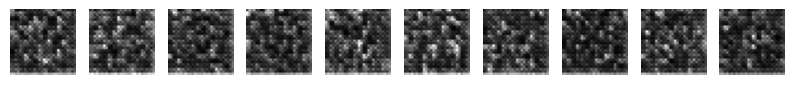

disc_loss 0.797837734 gen_loss 1.17923975 ssim 0.00138479029
disc_loss 0.870953321 gen_loss 1.14086115 ssim 0.0180431493
disc_loss 0.926340401 gen_loss 1.12039697 ssim -0.00719971349
disc_loss 0.931376815 gen_loss 1.15603256 ssim 0.00162694452
disc_loss 0.848856688 gen_loss 1.27008498 ssim -0.00118867308
disc_loss 0.72120434 gen_loss 1.16812968 ssim -0.016622914
disc_loss 0.79092139 gen_loss 1.27267492 ssim 0.0136196613
disc_loss 0.947948456 gen_loss 1.24027109 ssim 0.0398052819
disc_loss 0.913804054 gen_loss 1.0955807 ssim 0.0453017764
disc_loss 0.875349879 gen_loss 1.21154761 ssim -0.0274678
disc_loss 0.709833443 gen_loss 1.20303655 ssim -0.0209752303
disc_loss 0.785735548 gen_loss 1.31426477 ssim -0.0119996266
disc_loss 0.847578883 gen_loss 1.23299587 ssim -0.0133530376
disc_loss 0.872848868 gen_loss 1.33769 ssim 0.021176314
disc_loss 0.776872814 gen_loss 1.28443384 ssim -0.0236177053
disc_loss 0.675626636 gen_loss 1.32633579 ssim -0.0108622797
disc_loss 0.743757367 gen_loss 1.32151

In [ ]:
@tf.function
def train_step(images, labels,num_unrolling_steps):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 28, 28, 1])


    generated_images = generator([noise, labels], training=True)
    real_output = discriminator([images, labels], training=True)
    fake_output = discriminator([generated_images, labels], training=True)
    disc_loss = discriminator_loss(real_output, fake_output)
    gen_loss = generator_loss(fake_output)


    for _ in range(num_unrolling_steps if disc_loss>.5 else 1):
        with tf.GradientTape() as disc_tape:
            generated_images = generator([noise, labels], training=True)

            real_output = discriminator([images, labels], training=True)
            fake_output = discriminator([generated_images, labels], training=True)

            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator([noise, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        ssim = compute_ssim(generated_images[:5])
        #gen_loss += ssim*.2
        gen_loss = generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss,'ssim',ssim)
def train(generator, discriminator, gan, epochs, batch_size,num_unrolling_steps):
    for epoch in range(epochs):
        for batch in range(len(x_train2) // batch_size):
            images = x_train2[batch * batch_size: (batch+1) * batch_size]
            labels = y_train2[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels,num_unrolling_steps)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            # Generate and save sample images
            noise = tf.random.normal([10, 28, 28, 1])
            sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
            generated_images = generator.predict([noise, sampled_labels])
            generated_images = generated_images#(generated_images * 0.5) + 0.5  # Rescale images from [-1, 1] to [0, 1]
            fig, axs = plt.subplots(1, 10, figsize=(10, 10))
            for i in range(10):
                axs[i].imshow(generated_images[i], cmap="gray")
                axs[i].axis("off")
            plt.show()

# Train the GAN
EPOCHS = 20000
BATCH_SIZE = 100
num_unrolling_steps = 5  # Set the desired number of unrolling steps
train(generator, discriminator, gan, EPOCHS, BATCH_SIZE,num_unrolling_steps=num_unrolling_steps)